## Data preparation

In [1]:
supernovae = ['SN2016fqr', 'SN2016fca', 'SN2016eja', 'SN2016ege','SN2016flu','SN2016blk',
             'SN2016fim', 'SN2016fib', 'SN2016fes', 'SN2016ezh', 'SN2016eyn', 'SN2016dln',
              'SN2016cvm', 'SN2016cvj', 'SN2016csg', 'SN2016ccs', 'SN2016afj', 'SN2016zr',
              'SN2015bl', 'SN2016ww'
             ]

In [2]:
import requests

In [3]:
type_1a = []
for supernova in supernovae:
    resp = requests.get('https://api.astrocats.space/{}'.format(supernova)).json()
    if resp[supernova]['claimedtype'][0]['value'] == 'Ia':
        type_1a.append({'name': supernova, 
                        'type': resp[supernova]['claimedtype'][0]['value'],
                        'redshift':float(resp[supernova]['redshift'][0]['value'])
                       })
    

In [4]:
from bs4 import BeautifulSoup

In [5]:
for supernova in type_1a:
    with open('./ExpandingUniverseLab/ExpandingUniverseLab/sndata/{}.html'.format(supernova['name'])) as f:
        soup = BeautifulSoup(f.read())
        peak_mag = soup.find_all('p')[6].contents[0]
        peak_mag = peak_mag.split('Peak mag : ')[1].split(' &pm; ')
        supernova['peak_mag'] = float(peak_mag[0])
        supernova['mag_error'] = float(peak_mag[1].strip())

In [19]:
M = 19.6
for supernova in type_1a:
    supernova['distance'] = 10**((float(supernova['peak_mag']) + M + 5)/(5))

In [20]:
from matplotlib import pyplot as plt

In [21]:
import pandas as pd
df = pd.DataFrame.from_dict(type_1a)

In [24]:
import numpy as np

In [22]:
print(df)

         name type  redshift  peak_mag  mag_error      distance
0   SN2016fca   Ia   0.02700     15.73       0.03  1.164126e+08
1   SN2016eja   Ia   0.02400     15.97       0.05  1.300170e+08
2   SN2016flu   Ia   0.03400     16.31       0.06  1.520548e+08
3   SN2016blk   Ia   0.02997     15.96       0.03  1.294196e+08
4   SN2016fim   Ia   0.08800     18.43       0.07  4.036454e+08
5   SN2016fib   Ia   0.08060     18.14       0.07  3.531832e+08
6   SN2016fes   Ia   0.05200     17.11       0.06  2.197860e+08
7   SN2016eyn   Ia   0.06500     17.70       0.08  2.884032e+08
8   SN2016cvm   Ia   0.06900     17.80       0.05  3.019952e+08
9   SN2016cvj   Ia   0.05800     17.44       0.04  2.558586e+08
10  SN2016csg   Ia   0.09200     18.43       0.07  4.036454e+08
11  SN2016ccs   Ia   0.06200     17.65       0.06  2.818383e+08
12   SN2015bl   Ia   0.09300     18.62       0.09  4.405549e+08
13   SN2016ww   Ia   0.09100     18.52       0.07  4.207266e+08


In [23]:
df['redshift_error'] = 0.005

In [161]:
df['distance_error'] = (10**((df['peak_mag'] + df['mag_error'] + M + 5)/(5)) - 10**((df['peak_mag'] - df['mag_error'] + M + 5)/(5)) )/2

In [162]:
df['distance_error']

0     1.608351e+06
1     2.994016e+06
2     4.201963e+06
3     1.788055e+06
4     1.301424e+07
5     1.138725e+07
6     6.073684e+06
7     1.062757e+07
8     6.954310e+06
9     4.713356e+06
10    1.301424e+07
11    7.788471e+06
12    1.826470e+07
13    1.356497e+07
Name: distance_error, dtype: float64

## Task 4

### 4.1 Supernovae distance determination

In [163]:
from sklearn.linear_model import LinearRegression

In [164]:
model = LinearRegression()
rshift = np.array(df['redshift']).reshape(-1,1)
model.fit(rshift, df['distance'])

LinearRegression()

In [165]:
print(model.score(rshift, df['distance']))
model.coef_

0.990145127464534


array([4.54226263e+09])

### => coresponds to 66.07 Hubble constant , 6.604637918e-5

In [166]:
max_fit = LinearRegression()
rshift = np.array(df['redshift']).reshape(-1,1)
max_fit.fit(rshift, df['distance'] + df['distance_error'])

LinearRegression()

In [167]:
print(max_fit.score(rshift, df['distance']))

max_fit.coef_

0.9829395336314318


array([4.7304454e+09])

### => corresponds to 6.57373355×10−5

In [168]:
min_fit = LinearRegression()
rshift = np.array(df['redshift'] - df['redshift_error']).reshape(-1,1)
min_fit.fit(rshift, df['distance'] - df['distance_error'])

LinearRegression()

In [169]:
print(min_fit.score(rshift, df['distance']))

min_fit.coef_

0.9829395336314319


array([4.35407985e+09])

### => corresponds to 6.63583425×10−5

### => max - min = 0.0621007E-5

In [170]:
hubble_straight_model = np.linspace(0.02, 0.1, 100)
predicted_distance = model.predict(hubble_straight_model[:, np.newaxis])

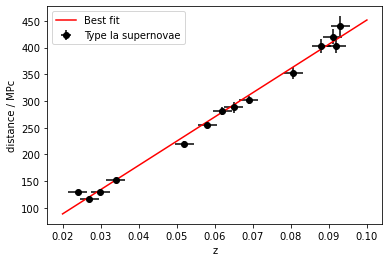

In [244]:
ax = plt.axes()
plt.errorbar(df['redshift'], df['distance'] * 1E-6,xerr=df['redshift_error'] * 0.5 , yerr=df['distance_error'] * 1E-6,fmt='o', color="black", label="Type Ia supernovae")
ax.plot(hubble_straight_model, predicted_distance * 1E-6, color="red", label="Best fit" )
plt.xlabel('z')
plt.ylabel('distance / MPc')
plt.legend(loc='upper left')
#plt.title('Measured redshift for Type Ia supernovae')
plt.savefig('measured_redshift_type_1a.png')

In [39]:
def simple_hubble_equation(z, c, h):
        return (c * z)/h # returns expected distance

In [40]:
def massless_hubble_equation(z, c, h):
    return ((c*z/h)*(1 + (z/2)))

In [41]:
import math
def mass_dominated_hubble_equation(z, c, h):
    return ((2*c/h)*(1 + z - math.sqrt(1 + z)))

### 4.2  Determining the best fit model and Hubble's constant

In [205]:
redshift_distance_error = 4.29 #MPc from theoretical straight line

In [228]:
massless_dataset = []
chisquare_series = []
for i in range(50,100,1):
    # i will be a  FACTOR the hubble constant
    hubble_constant_iteration = []
    chisum = 0
    for j in range(len(df['redshift'])):
        chisum += float(((massless_hubble_equation(z=df['redshift'][j], c=3E5, h = i) - df['distance'][j] * 1e-6)**2)/(10)**2)
    #print(chisum)
    chisquare_series.append(chisum)
#print(chisquare_series)
#print(np.min(chisquare_series))

In [229]:
print(np.min(chisquare_series))
print(chisquare_series)

15.895607795219247
[1858.219009397526, 1606.4204345432697, 1381.7469086818649, 1181.6944805909454, 1004.0150942934325, 846.687040666056, 707.8892363346533, 585.978780040508, 479.47132331546754, 387.0238641167308, 307.41963178414727, 239.55478149180465, 182.42665804229043, 135.12342382806946, 96.81487522171287, 66.74429650133676, 44.22122144252622, 28.614990546808794, 19.349007050408662, 15.895607795219247, 17.77147610213719, 24.533533259946413, 35.77525337611724, 51.12335333377328, 70.23481563277002, 92.79420710576059, 118.51126101285357, 147.11869393254602, 178.3702322678128, 212.03882614711824, 247.91503108225632, 285.8055400006404, 325.5318502435226, 366.9290518516728, 409.8447249787965, 454.1379356083163, 499.6783199249953, 546.3452487298102, 594.0270642022317, 642.6203821239386, 692.0294533951649, 742.1655793108849, 792.9465756287248, 844.2962809625503, 896.1441054825887, 948.4246163012401, 1001.0771562791576, 1054.0454933036694, 1107.2774973755954, 1160.724843094755]


In [230]:
mass_dominated_chisquare_series = []
for i in range(50,100,1):
    # i will be a  FACTOR the hubble constant
    hubble_constant_iteration = []
    chisum = 0
    for j in range(len(df['redshift'])):
        chisum += float(((mass_dominated_hubble_equation(z=df['redshift'][j], c=3E5, h = i) - df['distance'][j] * 1e-6)**2)/(10)**2)
    #print(chisum)
    mass_dominated_chisquare_series.append(chisum)
print(np.min(mass_dominated_chisquare_series))

16.528097355558295


In [261]:
simple_chisquare_series = []
for i in range(50,100,1):
    hubble_constant_iteration = []
    chisum = 0
    for j in range(len(df['redshift'])):
        chisum += float(((simple_hubble_equation(z=df['redshift'][j], c=3E5, h = i) - df['distance'][j] * 1E-6)**2)/10**2)
        #chisum += float(((simple_hubble_equation(z=df['redshift'][j], c=3E5, h = i) - df['distance'][j] * 1e-6)**2)/(10)**2)
    simple_chisquare_series.append(chisum)
print(np.min(simple_chisquare_series))

17.892387074101247


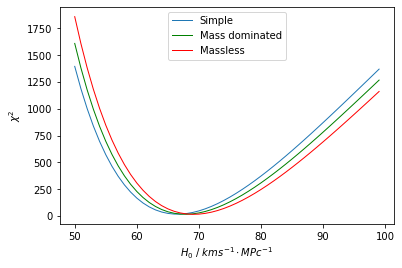

In [262]:
plt.plot([i for i in range(50,100,1)], simple_chisquare_series, label="Simple", linewidth=1)
plt.plot([i for i in range(50,100,1)], mass_dominated_chisquare_series, label="Mass dominated", linewidth=1, color="green")
plt.plot([i for i in range(50,100,1)], chisquare_series, label="Massless", linewidth=1, color="red")
plt.ylabel("$ \chi^{2}$")
plt.xlabel("$H_{0}$ / $kms^{-1} \cdot MPc^{-1}$")
plt.legend(loc="lower center")
plt.legend(loc="upper center")
#plt.title('$\chi^{2}$ and the Hubble constant - inspection of the models.')
plt.savefig('chisqaure_fit_models.png')

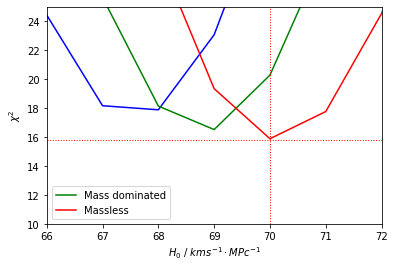

In [263]:
plt.plot([i for i in range(65,75,1)], simple_chisquare_series[14:24], color="blue")
plt.plot([i for i in range(65,75,1)], mass_dominated_chisquare_series[14:24], label="Mass dominated", color="green")
plt.plot([i for i in range(65,75,1)], chisquare_series[14:24],  label="Massless", color="red")

plt.xlim( [ 66, 72 ] ) 
plt.ylim( [ 10, 25 ] )
plt.ylabel("$ \chi^{2}$")
plt.xlabel("$H_{0}$ / $kms^{-1} \cdot MPc^{-1}$")
plt.axvline(x=70, color='red', linestyle='dotted', linewidth=1)
plt.axhline(y=15.8,color='red', linestyle='dotted', linewidth=1)
# Y ticks every 50.  You can provide any list.
#plt.# Plot from y=0 to y=250.
plt.legend(loc="lower left")
plt.savefig('zoomed_in_chi_square.png')

## Task 5

In [69]:
reiss_data = pd.read_csv('./ExpandingUniverseLab/ExpandingUniverseLab/sndata/reiss1998.txt',delimiter="\t")

In [70]:
reiss_data

,SN,z,z_error,mod_d,d_error
0,1996E,0.43,0.01,41.74,0.38
1,1996H,0.62,0.01,42.98,0.17
2,1996I,0.57,0.01,42.76,0.19
3,1996J,0.30,0.01,41.38,0.24
4,1996K,0.38,0.01,41.63,0.20
5,1996U,0.43,0.01,42.55,0.25
6,1997ce,0.44,0.01,41.95,0.17
7,1997cj,0.50,0.01,42.40,0.17
8,1997ck,0.97,0.01,44.39,0.30
9,1995K,0.48,0.01,42.45,0.17


In [129]:
reiss_data['d'] = 10**((reiss_data['mod_d'] + 5)/5)
reiss_data['distance_error'] =  (10**((reiss_data['mod_d'] +  reiss_data['d_error'] + 5)/5) - 10**((reiss_data['mod_d'] -  reiss_data['d_error'] + 5)/5))/2

In [130]:
print(reiss_data)

       SN     z  z_error  mod_d  d_error             d  distance_error
0   1996E  0.43     0.01  41.74     0.38  2.228435e+09    3.919617e+08
1   1996H  0.62     0.01  42.98     0.17  3.944573e+09    3.091279e+08
2   1996I  0.57     0.01  42.76     0.19  3.564511e+09    3.122866e+08
3   1996J  0.30     0.01  41.38     0.24  1.887991e+09    2.090936e+08
4   1996K  0.38     0.01  41.63     0.20  2.118361e+09    1.953842e+08
5   1996U  0.43     0.01  42.55     0.25  3.235937e+09    3.733745e+08
6  1997ce  0.44     0.01  41.95     0.17  2.454709e+09    1.923704e+08
7  1997cj  0.50     0.01  42.40     0.17  3.019952e+09    2.366672e+08
8  1997ck  0.97     0.01  44.39     0.30  7.550922e+09    1.046520e+09
9   1995K  0.48     0.01  42.45     0.17  3.090295e+09    2.421799e+08


In [131]:
hubble_straight_model_extended = np.linspace(0, 1, 100)
predicted_distance_extended = model.predict(hubble_straight_model[:, np.newaxis])

In [132]:
hubble_massless_model = np.linspace(0, 1, 100)
predicted_distance_massless = [massless_hubble_equation(z=i, c=3E5, h=70 ) for i in hubble_massless_model]

In [133]:
hubble_mass_dominant_model = np.linspace(0, 1, 100)
predicted_distance_mass_dominant = [mass_dominated_hubble_equation(z=i, c=3E5, h=70 ) for i in hubble_massless_model]

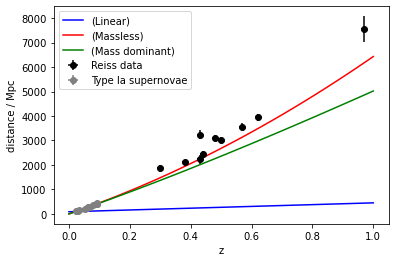

In [284]:
plt.errorbar(reiss_data['z'] , reiss_data['d'] * 1e-6, xerr=reiss_data['z_error'], yerr=reiss_data['distance_error'] * 0.5  * 1E-6, fmt="o", color="black", label="Reiss data")
plt.errorbar(df['redshift'], df['distance'] * 1E-6,xerr=df['redshift_error'] * 0.5 , yerr=df['distance_error'] * 1E-6,fmt='o', color="grey", label="Type Ia supernovae")
plt.plot(hubble_straight_model_extended, predicted_distance_extended * 1E-6, color="blue", label="(Linear)")
plt.plot(hubble_massless_model, predicted_distance_massless, color="red", label="(Massless)")
plt.plot(hubble_mass_dominant_model, predicted_distance_mass_dominant, color="green", label="(Mass dominant)")
plt.legend(loc="upper left")
plt.ylabel('distance / Mpc')
plt.xlabel('z')
#plt.title("Higher redshift regime - ")
plt.savefig("reiss_data.png")

In [264]:
#mass_dominated_dataset = []
nobel_massless_chisquare_series = []
for i in range(40,100,1):
    # i will be a  FACTOR the hubble constant
    chisum = 0
    for j in range(len(reiss_data['z'])):
        chisum +=((reiss_data['d'][j] * 1e-6 - massless_hubble_equation(z=reiss_data['z'][j], c=3E5, h = i))**2/(reiss_data['distance_error'][j] * 1e-6)**2)
    for j in range(len(df['redshift'])):
        chisum += float(((massless_hubble_equation(z=df['redshift'][j], c=3E5, h = i) - df['distance'][j] * 1E-6)**2)/10**2)
    nobel_massless_chisquare_series.append(chisum)
print(np.min(nobel_massless_chisquare_series))
print(nobel_massless_chisquare_series)

37.74586509654079
[7009.905738178259, 6216.941766237687, 5506.225299638336, 4868.986554696935, 4297.522335879838, 3785.0482649127093, 3325.5740180478424, 2913.797600491792, 2545.0154376474097, 2215.0456596205854, 1920.1624322858222, 1657.0395710250716, 1422.701981994824, 1214.4837258625596, 1029.9917023792807, 867.0741202922875, 723.7930533120182, 598.4004949353459, 489.317417496885, 395.1154175323862, 314.5005933214116, 246.29935367913458, 189.4459015814697, 142.9711735637216, 105.99304727192016, 77.70765607888526, 57.38167212968954, 44.34543823049603, 37.98684519736109, 37.74586509654079, 43.10966261485619, 53.608216912733965, 68.81039499566364, 88.32042511054243, 111.77472511445819, 138.83904632810615, 169.20589820300432, 202.5922233094351, 238.7372957821927, 277.4008195212645, 318.36120520026475, 361.41400754264765, 406.37050643204304, 453.05641726911534, 501.31071760784397, 550.9845785288705, 601.9403904620556, 654.0508742766244, 707.1982694341825, 761.2735918637773, 816.175954983

In [265]:
#mass_dominated_dataset = []
nobel_mass_dominant_chisquare_series = []
for i in range(30,100,1):
    # i will be a  FACTOR the hubble constant
    chisum = 0
    for j in range(len(reiss_data['z'])):
        #chisum += float(((mass_dominated_hubble_equation(z=reiss_data['z'][j], c=3E5, h = i) - reiss_data['d'][j] * 1E-6)**2)/100**2)
        chisum +=((reiss_data['d'][j] * 1e-6 - mass_dominated_hubble_equation(z=reiss_data['z'][j], c=3E5, h = i))**2/(reiss_data['distance_error'][j] * 1e-6)**2)
    for j in range(len(df['redshift'])):
        chisum += float(((mass_dominated_hubble_equation(z=df['redshift'][j], c=3E5, h = i) - df['distance'][j] * 1E-6)**2)/10**2)       

    nobel_mass_dominant_chisquare_series.append(chisum)
print(np.min(nobel_mass_dominant_chisquare_series))
print(nobel_mass_dominant_chisquare_series)

69.83334300048662
[20698.535865436275, 18355.019578155658, 16286.26732605337, 14455.990873008126, 12833.462604748434, 11392.541937166245, 10110.893029725505, 8969.352265577782, 7951.413800681335, 7042.808807592266, 6231.159535042475, 5505.693460644984, 4857.005980825742, 4276.862511933547, 3758.0327533624904, 3294.151322474354, 2879.6001120356736, 2509.4086182347346, 2179.1691969833814, 1884.964770335287, 1623.3069555425864, 1391.0829510549943, 1185.5098055058252, 1004.0949320176527, 844.6019223400413, 705.0208722663355, 583.5425584259875, 478.5359124032828, 388.5283255436277, 312.1883902371142, 248.31074368282106, 195.80273035663782, 153.67264141833422, 121.01932454604018, 97.0229873512021, 80.93704255951371, 72.0808643235764, 69.83334300048662, 73.62714100800204, 82.94356539990561, 97.30798393327191, 116.28572093498211, 139.47837745941138, 166.52052727004448, 197.07674624738388, 230.83893806851816, 267.52392354160077, 306.87126491369384, 348.64129988928767, 392.6133630725355, 438.584

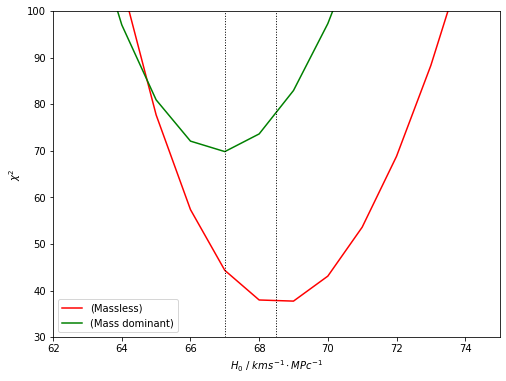

In [283]:
plt.figure(figsize=(8,6))
plt.plot([i for i in range(40,100,1)], nobel_massless_chisquare_series, color="red", label="(Massless)")
plt.plot([i for i in range(30,100,1)], nobel_mass_dominant_chisquare_series, color="green", label="(Mass dominant)")
plt.ylim([30, 100])
plt.xlim([62, 75])
plt.ylabel('$ \chi^2 $')
plt.axvline(x=68.5, color='black', linestyle='dotted', linewidth=1)
plt.axvline(x=67, color='black', linestyle='dotted', linewidth=1)
plt.xlabel('$H_0$ / $kms^{-1} \cdot MPc^{-1}$')
#plt.title("Chi square fit for Reiss data")
plt.legend(loc='lower left')
plt.savefig("reiss_chi.png")

## Task 6

In [145]:
theoretical_DL = pd.read_csv('./ExpandingUniverseLab/ExpandingUniverseLab/sndata/theoretical_DL.txt', delimiter=r"\s+")

In [146]:
theoretical_DL

,redshift,theoretical_distance
0,0.0001,0.856767
1,0.0003,1.713800
2,0.0005,2.571098
3,0.0007,3.428662
4,0.0009,4.286491
...,...,...
9995,1.9995,15535.239000
9996,1.9997,15537.142000
9997,1.9999,15539.044000
9998,2.0001,15540.947000


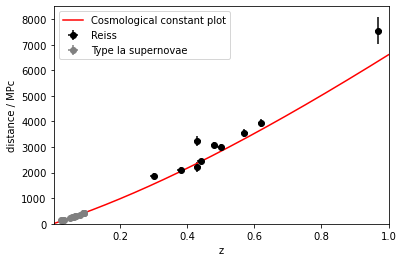

In [241]:
plt.plot(theoretical_DL['redshift'], theoretical_DL['theoretical_distance'], color="red", label="Cosmological constant plot")
plt.errorbar(reiss_data['z'] , reiss_data['d'] * 1E-6, xerr=reiss_data['z_error'], yerr=reiss_data['distance_error']  * 1E-6 * 0.5, fmt="o", color="black", label="Reiss")
plt.errorbar(df['redshift'], df['distance'] * 1E-6,xerr=df['redshift_error'] , yerr=df['distance_error'] * 1E-6,fmt='o', color="grey", label="Type Ia supernovae")
plt.xlim([0.002, 1.00])
plt.ylim([0, 8500])
plt.legend(loc="upper left")
plt.xlabel('z')
plt.ylabel('distance / MPc')
#plt.title('Matter and dark energy theoretical model with both datasets')
plt.savefig('task6.png')

In [236]:
interpolated_values = []
for i in df['redshift']:

    close_values = theoretical_DL.query('redshift >= {} and redshift <= {}'.format(i - 0.0005, i + 0.0005))
    closest_value = round(float(min(close_values['redshift'], key = lambda x: abs(x-i))), 6)
  

    x = theoretical_DL.query('redshift >= {} and redshift < {}'.format(closest_value, closest_value + 0.0005))
    interpolated_values.append(x.iloc[0])

In [237]:
task6_chisquare_series = []
chisum = 0
for j in range(len(df['redshift'])):
    chisum += float(((df['distance'][j] *1E-6 -  interpolated_values[j]['theoretical_distance'])**2)/10**2)
print(chisum)

15.83234714866088


In [151]:
interpolated_values = []
for i in reiss_data['z']:

    close_values = theoretical_DL.query('redshift >= {} and redshift <= {}'.format(i - 0.0005, i + 0.0005))
    closest_value = round(float(min(close_values['redshift'], key = lambda x: abs(x-i))), 6)
  

    x = theoretical_DL.query('redshift >= {} and redshift < {}'.format(closest_value, closest_value + 0.0005))
    interpolated_values.append(x.iloc[0])

In [154]:
task6_reiss_chisquare_series = []
chisum_reiss = 0
for j in range(len(reiss_data['z'])):
    #chisum_reiss += float(((reiss_data['d'][j] *1E-6 -  interpolated_values[j]['theoretical_distance'])**2)/(100)**2)
    chisum_reiss +=(reiss_data['d'][j] * 1e-6 - interpolated_values[j]['theoretical_distance'])**2/(reiss_data['distance_error'][j] * 1e-6)**2
print(chisum_reiss)


14.162543673330376
